In [1]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt

# Laplace equaiton

$$ -\Delta u = 1 $$

$$ u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0 $$

$$ [0, 1]\times [0, 1] $$

## Numerical parameters

$$ n = 50 $$

In [2]:
# x shape [51, 51]
n = 50
h = 1 / n

def Laplacian(u):
    # x shape [49, 49]
    x = np.zeros((51, 51))
    x[1:-1, 1:-1] = u
    # interior points
    lap_u = -(x[:-2, 1:-1] + x[2:, 1:-1] 
             + x[1:-1,:-2] + x[1:-1, 2:]
             - 4 * x[1:-1, 1:-1]) / h ** 2

    return lap_u

In [3]:
from scipy.fftpack import fft, dst

def idst_2d(a):
    return dst(dst(a, type=1, axis=1, norm='ortho'), type=1, axis=0, norm='ortho')

def dst_2d(a):
    return dst(dst(a, type=1, axis=1, norm='ortho'), type=1, axis=0, norm='ortho')

In [4]:
def preconditioner(f, h, n):
    lambda_ = np.zeros((n-1,n-1))
    lambda_[:,:] = 4*((np.sin(0.5*np.arange(1, n)*np.pi/n)**2/h**2)[:,None] 
                        + (np.sin(0.5*np.arange(1, n)*np.pi/n)**2/h**2))
    f_hat = dst_2d(f)
    return idst_2d(f_hat/lambda_)

In [18]:
x = np.linspace(0, 1, 49)
y = np.linspace(0, 1, 49)
z = x[:, None] + y
sol = preconditioner(np.ones((49, 49)), h, n)

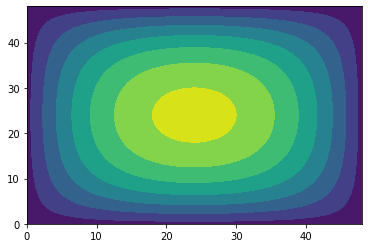

In [19]:
plt.contourf(sol)

In [18]:
def steepest_descent(lapl, f):
    n_iter = 0
    u = np.zeros((49, 49))
    r = f - lapl(u)
    for _ in range(10000):
        w = lapl(r)
        r_norm = np.sum(r ** 2)
        if np.sqrt(r_norm) < 1e-5:
            break
        alpha = r_norm / (np.sum(r * w) + 1e-8)
        u = u + alpha * r
        r = r - alpha * w
        n_iter += 1
    
    return u, n_iter

In [37]:
out, n = steepest_descent(Laplacian, 2.0)

In [20]:
def CG(lapl, f):
    n_iter = 0
    u = np.zeros((49, 49))
    r = f - lapl(u)
    p = r.copy()
    r_old = np.sum(r ** 2)
    for _ in range(10000):
        w = lapl(p)
        if np.sqrt(r_old) < 1e-5:
            break
        alpha = r_old / (np.sum(p * w) + 1e-8)
        u = u + alpha * p
        r = r - alpha * w
        r_norm = np.sum(r ** 2)
        beta = r_norm / r_old
        p = r + beta * p
        n_iter += 1
        r_old = r_norm
    
    return u, n_iter

In [21]:
out_cg, n_cg = CG(Laplacian, 1.0)

In [22]:
n_cg

83

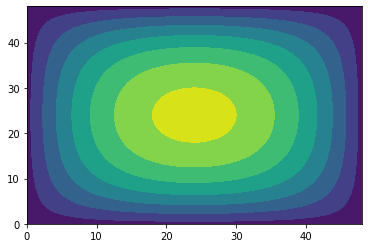

In [23]:
plt.contourf(out_cg)

In [24]:
np.mean((out_cg - sol) ** 2)

1.9936527192698742e-20

In [25]:
def PCG(lapl, f):
    n_iter = 0
    u = np.zeros((49, 49))
    r = f - lapl(u)
    z = preconditioner(r, h, n)
    p = z.copy()
    for _ in range(10000):
        w = lapl(p)
        r_old = np.sum(r * r)
        alpha = r_old / (np.sum(p * w))
        u = u + alpha * p
        r = r - alpha * w
        if np.sqrt(np.sum(r * r)) < 1e-4:
            break
        z = preconditioner(r, h, n)
        beta = np.sum(z * r) / r_old
        p = z + beta * p
        n_iter += 1
    
    return u, n_iter

In [26]:
out_pcg, n_pcg = PCG(Laplacian, 1.0)

<ipython-input-25-100117e3a9a1>:13: RuntimeWarning: overflow encountered in multiply
  if np.sqrt(np.sum(r * r)) < 1e-4:
<ipython-input-25-100117e3a9a1>:16: RuntimeWarning: overflow encountered in multiply
  beta = np.sum(z * r) / r_old
<ipython-input-25-100117e3a9a1>:9: RuntimeWarning: overflow encountered in multiply
  r_old = np.sum(r * r)
